In [1]:
import tensorflow as tf
import tensorflow_hub as hub





TF version: 2.15.0
Hub version: 0.15.0
GPU is NOT AVAILABLE


In [3]:
import os

In [2]:
model = hub.load("https://www.kaggle.com/models/google/movenet/frameworks/TensorFlow2/variations/singlepose-thunder/versions/4")
movenet = model.signatures['serving_default']

In [24]:

path = "../../Datasets/Trainer/raw/situp_1.jpg"
image_path = path
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)

In [19]:
# Run model inference.
outputs = movenet(image)
# Output is a [1, 1, 17, 3] tensor.
keypoints = outputs['output_0']
print(keypoints.shape)

(1, 1, 17, 3)


In [20]:
# model = tf.keras.Sequential([
#     hub.KerasLayer("https://tfhub.dev/google/movenet/singlepose/thunder/4", trainable=True)
# ])

ValueError: Signature name has to be specified for non-callable saved models (if not legacy TF1 Hub format).

In [57]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [41]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.compat.v1.image.decode_jpeg(image)
    image = tf.expand_dims(image, axis=0)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
    return image

def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image[0])
    plt.show()


def predict(image_path):
    image = load_image(image_path)
    outputs = movenet(image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints = outputs['output_0']
    #draw the keypoint on image:
    image_with_keypoints = image
    display_image(image_with_keypoints)

In [66]:
class PoseDetector:
    def __init__(self, model_path):
        self.movenet = self.load_model(model_path)
    
    def load_model(self,model_path):
        self.model = hub.load(model_path)
        movenet = model.signatures['serving_default']
        return movenet

    def detect(self,input_image,inference_count=3):
        input_image = tf.cast(input_image, dtype=tf.int32)
        outputs = movenet(input_image)
        keypoints_with_scores = outputs['output_0'].numpy()
        print(keypoints_with_scores.shape)
        return keypoints_with_scores

In [58]:
from matplotlib.collections import LineCollection
import matplotlib.patches as patches


In [59]:
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [74]:
class ImageProcessor:
    def process_image(self,image_path):
        image = tf.io.read_file(image_path)
        image = tf.compat.v1.image.decode_jpeg(image)
        image = tf.expand_dims(image, axis=0)
        image = tf.cast(tf.image.resize_with_pad(image, 256, 256), dtype=tf.int32)
        return image
    
    def display_image(self,image):
        fig = plt.figure(figsize=(20, 15))
        plt.grid(False)
        plt.imshow(image[0])
        plt.show()
        
    def display_image_with_keypoints(self,image,keypoints):
        display_image = tf.cast(tf.image.resize_with_pad(
            image, 1280, 1280), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(
            np.squeeze(display_image.numpy(), axis=0), keypoints)
        plt.figure(figsize=(5, 5))
        plt.imshow(output_overlay)
        _ = plt.axis('off')
        

In [68]:
Detector = PoseDetector("https://tfhub.dev/google/movenet/singlepose/thunder/4")

In [75]:
ImageProcessor = ImageProcessor()

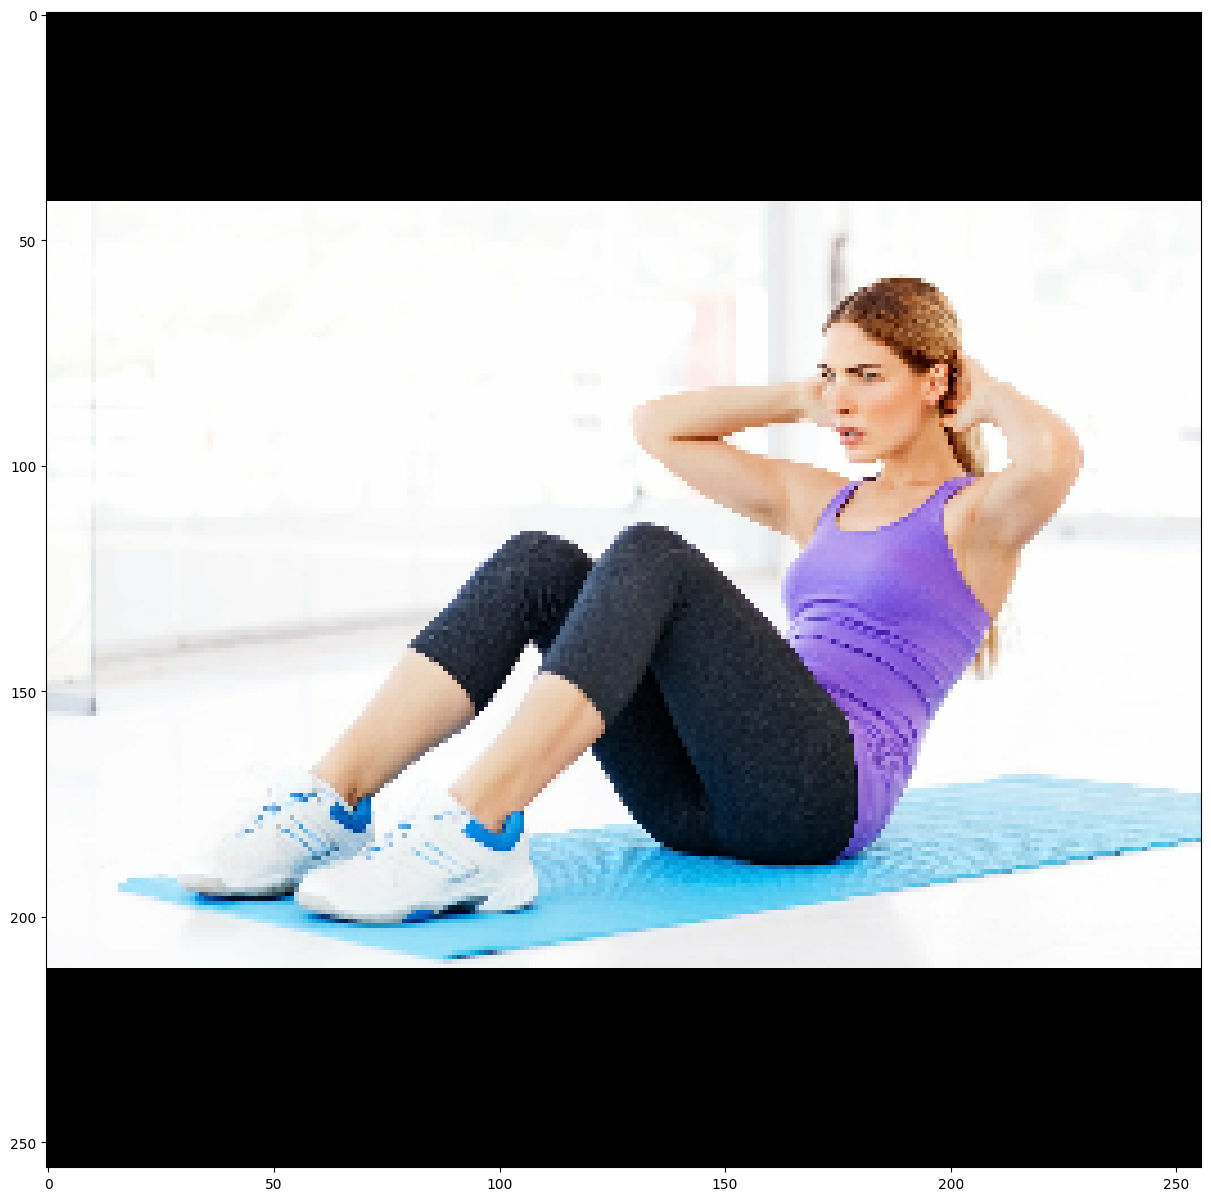

(1, 1, 17, 3)


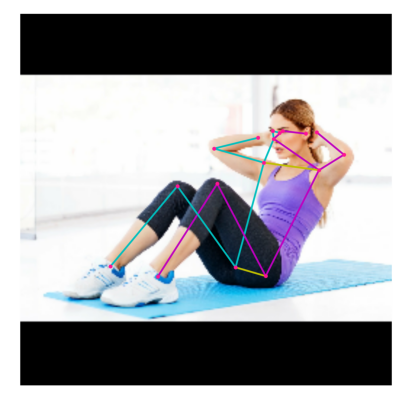

In [76]:
image = ImageProcessor.process_image(path)
ImageProcessor.display_image(image)
keypoints = Detector.detect(image)
ImageProcessor.display_image_with_keypoints(image,keypoints)